<a href="https://colab.research.google.com/github/battistabiggio/ai4dev/blob/main/notebooks/AI4Dev_03_ml_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML model training pipeline

To create good ML models, we need to design a full process in which we can inspect the behavior of the models under different settings.

Some models can be tuned to have specific behaviors under the effect of specific settings named **hyperparameters**. These are model configurations that change the shape of the decision function and other aspects of the learning process.

To pick the best hyperparameters, we have to test different instances of models and rank them according to the performance scores obtained.

Testing the model on the training dataset causes the model to perform very well on the training data, but we risk failure in predicting unseen data.
This issue is called **overfitting** and its effect prevents the model from **generalizing**.

To avoid overfitting, it is common practice to:
* take a part of the available data for training
* take the rest for testing (unseen in training)

Now, if we want also to pick the hyperparameters that generalize well, we have to train the model with a set and evaluate on a separate set.
This is why we introduce a third subset called the validation set.




The order of steps and the role of each set is the following:

1. Take the available data and split in design set and testing set. The testing set should be used only at the end (i.e., even after the selection of the hyperparameters). It is used only for testing the model in a setting similar to the real-world, when it is deployed in production.
2. Divide the design set into two separate sets:
  - training set, used to train each of the candidate models
  - validation set, used to score each of the trained candidate models
3. Rank the models according to the performance metric (e.g., accuracy)
4. Pick the model that performs the best on the validation set.
5. Test the model on the testing set. This is an estimation on how the model will work in the real word.

Note also that, as we will do later in the notebook, step 2 can be performed multiple times with separate splits, so that we can compute average performances across multiple experiments (and thus avoid "lucky guesses" of the parameters).

First, we will import some functions from the last notebook. We will use again scatter plots to represent the points in our dataset, and we will visualize the decision functions of the classifiers to evaluate visually how they behave with different hyperparameters.

In [1]:
import numpy as np

from sklearn import svm
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_moons

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def get_cmap_and_colors(n_classes):
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    cmap = ListedColormap(colors[:n_classes])
    return cmap, colors

# taken from previous notebook
def plot_dataset(x, y):
    _, colors = get_cmap_and_colors(len(np.unique(y)))
    available_classes = np.unique(y)  # takes the unique elements
    for c in sorted(available_classes):
        samples_from_class = x[y==c]
        x_coords = samples_from_class[:, 0]
        y_coords = samples_from_class[:, 1]
        plt.scatter(x_coords, y_coords, label=str(c), color=colors[c])  # plots also sets of points
    plt.xlabel('feature x1')
    plt.ylabel('feature x2')
    plt.legend()

# taken from previous notebook
def plot_decision_regions(x, y, classifier, num_points=100):
    cmap, _ = get_cmap_and_colors(len(np.unique(y)))
    # get maximum and minimum value for each feature (with a bit of margin)
    factor = 1.05
    x1_min, x1_max = x[:, 0].min() * factor, x[:, 0].max() * factor
    x2_min, x2_max = x[:, 1].min() * factor, x[:, 1].max() * factor


    # create coordinate matrices from coordinate vectors
    xx1, xx2 = np.meshgrid(
        np.linspace(x1_min, x1_max, num_points),
        np.linspace(x2_min, x2_max, num_points))

    # get color value for each coordinate (as feature 1 and feature 2)
    z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)

    # shape again as a grid
    z = z.reshape(xx1.shape)

    # plot the colors
    plt.contourf(xx1, xx2, z, alpha=0.4, cmap=cmap)

    # set plot limits
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    plot_dataset(x,y)


We now sample fom the two-moon dataset, defined in scikit-learn. This dataset is more challenging than the one before, as the data are not easy to separate e.g., with a linear classifier. For this reason, we will use an SVM with a Gaussian kernel to classify these data.

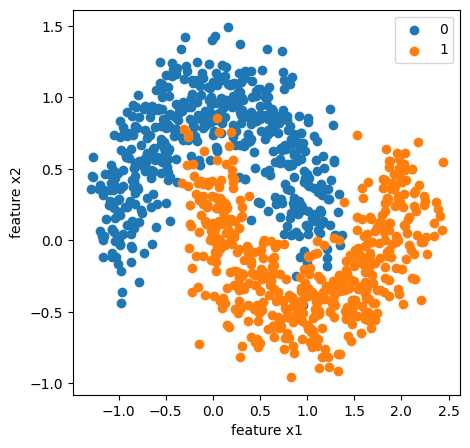

In [2]:
from sklearn.datasets import make_moons

# sample data
x, y = make_moons(n_samples=1000, noise=0.2)
plt.figure(figsize=(5,5))
plot_dataset(x,y)

## Performance Evaluation

As discussed above, we are risking overfitting if we use the testing data for finding good hyperparameters. This is because some information on the test set can "leak" into the model, making the experiment less realistic.

We have to first hold out the training data and use it only at the end of the design pipeline.

Then, from the remaining data, we can divide the dataset into training and validation sets. However, dividing many times the dataset might lead to small subsets. For this reason, we use k-fold cross validation, i.e., we split multiple times the design set and average the performances over multiple runs of the experiment.

We can first take a look at what the classifier learns with ranges of hyperparameters. We will use a SVM classifier with a Gaussian kernel.

The main parameters that we are going to change are `C` (the regularization parameter) and `gamma` (the kernel coefficient). We now define some values and test the classifiers with all the combinations of these two hyperparameters.

First, let's define what happens in a single run. We have to create multiple splits, train a classifier on the training subset and test it on a validation set, and average the performances across the different splits.


In [3]:
x, y = make_moons(n_samples=1000, noise=0.2)

splitter = ShuffleSplit(n_splits=5, random_state=0, train_size=0.5)

scaler = MinMaxScaler()
clf = svm.SVC(kernel='rbf', C=10, gamma=10.0)
clf_name = 'SVM RBF'

for split_idx, (tr_idx, ts_idx) in enumerate(splitter.split(x, y)):
    x_train = x[tr_idx, :]
    y_train = y[tr_idx]
    x_val = x[ts_idx, :]
    y_val = y[ts_idx]

    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_val)

    accuracy = (y_pred == y_val).mean()

    print(f"Run: {split_idx} - Validation accuracy: {accuracy:.1%}")

Run: 0 - Validation accuracy: 95.4%
Run: 1 - Validation accuracy: 96.4%
Run: 2 - Validation accuracy: 97.2%
Run: 3 - Validation accuracy: 97.0%
Run: 4 - Validation accuracy: 97.6%


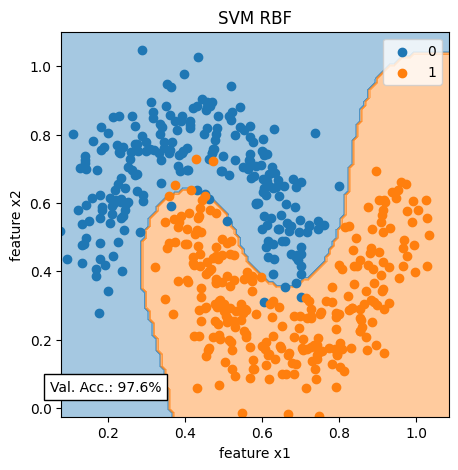

In [4]:
# plot the last classifier
plt.figure(figsize=(5, 5))
plt.title(clf_name)
plot_decision_regions(x_val, y_val, clf)
plt.text(0.05, 0.05, "Val. Acc.: {:.1%}".format(accuracy),
        bbox=dict(facecolor='white'))
plt.show()

Now, let's code this procedure as a function `run`.
We will store the accuracy values and then return the list of accuracies for each run.

In [5]:
def run(x, y, splitter, scaler, clf):
    """Take input data (x,y), split it (n times), scale it,
    learn classifier on training data, and evaluate the mean test error.
    """
    acc = np.zeros(shape=(splitter.get_n_splits(),))

    for i, (tr_idx, ts_idx) in enumerate(splitter.split(x, y)):
        xtr = x[tr_idx, :]
        ytr = y[tr_idx]
        xts = x[ts_idx, :]
        yts = y[ts_idx]

        xtr = scaler.fit_transform(xtr)
        xts = scaler.transform(xts)

        clf.fit(xtr, ytr)
        ypred = clf.predict(xts)
        acc[i] = (ypred == yts).mean()
    return acc


# sample data
x, y = make_moons(n_samples=500, noise=0.2)

splitter = ShuffleSplit(n_splits=10, random_state=0, train_size=0.5)

scaler = MinMaxScaler()
clf = svm.SVC(kernel='linear', C=1)
acc = run(x, y, splitter, scaler, clf)
print("Mean test accuracy: {:.1%} +/- {:.1%}".format(acc.mean(), 2*acc.std()))


Mean test accuracy: 85.2% +/- 2.5%


Let's test a few classifiers now and see how the decision function changes depending on the parameters.

First, let's define the range of parameters (and let's get all the combinations).


In [6]:
from itertools import product

C_values = [1, 1e1, 1e2]
gamma_values = [1e-1, 1, 1e2]

combinations = list(product(C_values, gamma_values))

print(combinations)

[(1, 0.1), (1, 1), (1, 100.0), (10.0, 0.1), (10.0, 1), (10.0, 100.0), (100.0, 0.1), (100.0, 1), (100.0, 100.0)]


Then, let's create a plot where we visualize the decision function for each couple of hyperparameters defined.

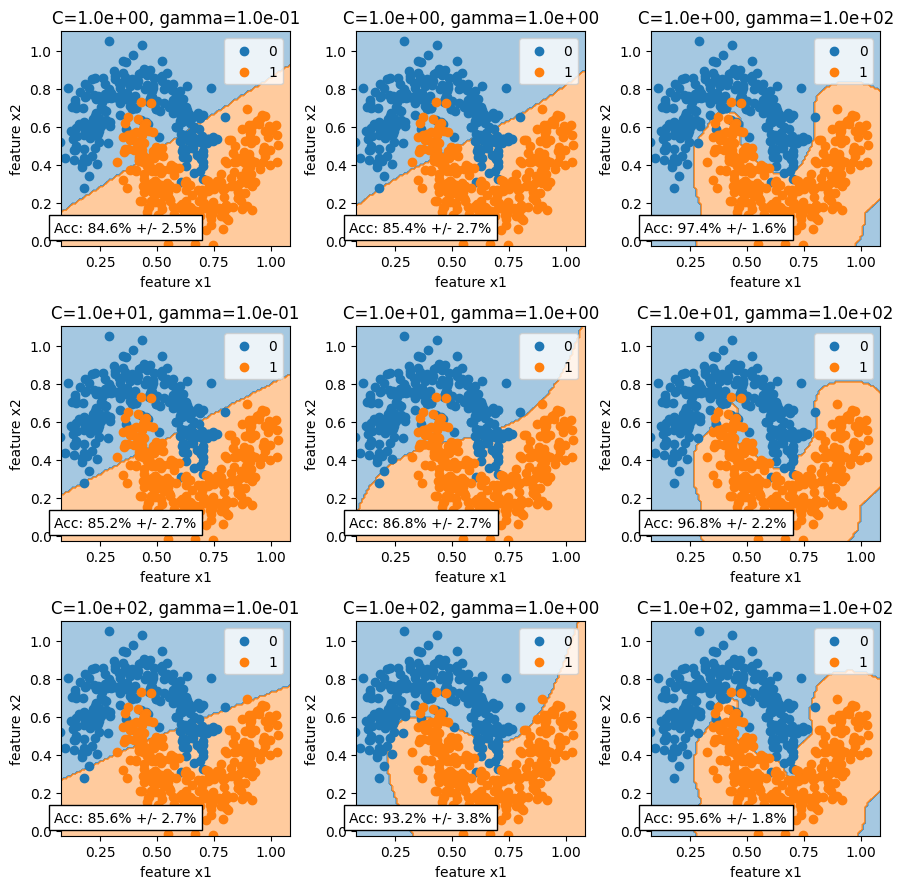

In [7]:
n_cols = len(C_values)
n_rows = len(gamma_values)
fig = plt.figure(figsize=(3*n_cols, 3*n_rows))
for i, (C, gamma) in enumerate(combinations):
    clf = svm.SVC(kernel='rbf', C=C, gamma=gamma)
    acc = run(x, y, splitter, scaler, clf)
    plt.subplot(n_rows, n_cols, i+1)
    plot_decision_regions(x_val, y_val, clf)
    plt.title(f"C={C:.1e}, gamma={gamma:.1e}")
    plt.text(0.05, 0.05, "Acc: {:.1%} +/- {:.1%}".format(acc.mean(), 2*acc.std()),
             bbox=dict(facecolor='white'))

plt.tight_layout()


This already helps us finding a good-enough model for this simple problem. Of course, we might want to test more values, and we don't always have 2D data to visualize. For this reason, we will now build a loop to perform the sweep over the hyperparameters (grid search) and to find the best classifier depending on how it performs on the validation dataset.

## Hyperparameter Estimation

Often, in machine learning, we have to configure the algorithms depending on the data distribution and characteristics of the classification problem (e.g., number of classes, noise, etc.).

To do so, we saw that we can perform grid search and cross validation to test the hyperparameters in multiple settings.

Let's now rank the classifiers depending on their performances on the validation set(s).

For each `C` value,  we have to compute the mean validation accuracy (averaged on the K folds). We have to do the same for each `gamma` value.
Then, we will select the `C` and `gamma` value corresponding to the maximum mean validation accuracy, and use those values to train our classifier on the whole training set.

This procedure is already implemented by the `GridSearchCV` wrapper class from sklearn, and we will use it along with our `run` function.

Reference for grid search cross validation on sklearn:
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

Let's start by performing the search with the `make_moons` dataset.


Hyperparameter estimation (5-fold xval)
    - Grid scores on development set:
        Acc: 0.570 (+/-0.280) for {'C': 0.01, 'gamma': 0.01}
        Acc: 0.570 (+/-0.280) for {'C': 0.01, 'gamma': 0.1}
        Acc: 0.676 (+/-0.187) for {'C': 0.01, 'gamma': 1}
        Acc: 0.596 (+/-0.384) for {'C': 0.01, 'gamma': 100.0}
        Acc: 0.590 (+/-0.360) for {'C': 0.01, 'gamma': 1000.0}
        Acc: 0.570 (+/-0.280) for {'C': 0.1, 'gamma': 0.01}
        Acc: 0.842 (+/-0.029) for {'C': 0.1, 'gamma': 0.1}
        Acc: 0.856 (+/-0.027) for {'C': 0.1, 'gamma': 1}
        Acc: 0.966 (+/-0.043) for {'C': 0.1, 'gamma': 100.0}
        Acc: 0.654 (+/-0.301) for {'C': 0.1, 'gamma': 1000.0}
        Acc: 0.854 (+/-0.041) for {'C': 1, 'gamma': 0.01}
        Acc: 0.856 (+/-0.027) for {'C': 1, 'gamma': 0.1}
        Acc: 0.864 (+/-0.041) for {'C': 1, 'gamma': 1}
        Acc: 0.958 (+/-0.046) for {'C': 1, 'gamma': 100.0}
        Acc: 0.944 (+/-0.060) for {'C': 1, 'gamma': 1000.0}
        Acc: 0.856 (+/-0.027) 

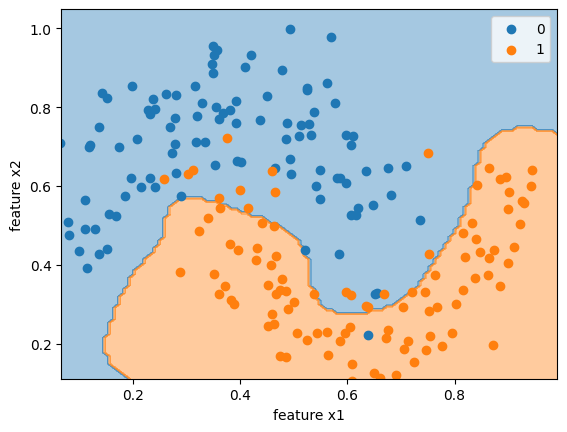

In [8]:
from sklearn.model_selection import GridSearchCV

x, y = make_moons(n_samples=1000, noise=0.2)

scaler = MinMaxScaler()
splitter = ShuffleSplit(n_splits=5, random_state=0, train_size=0.5)

C_values = [0.01, 0.1, 1, 10, 100]
gamma_values = [1e-2, 1e-1, 1, 1e2, 1e3]

# creates the grid search setup
clf = GridSearchCV(estimator=svm.SVC(kernel='rbf'),
                   param_grid={"C": C_values, "gamma": gamma_values})

acc = run(x, y, splitter, scaler, clf)

print("Hyperparameter estimation (5-fold xval)")
print("    - Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("        Acc: %0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

x_test, y_test = make_moons(n_samples=200, noise=0.2)
x_test = scaler.transform(x_test)

acc = run(x_test, y_test, splitter, scaler, clf)
print("    - Best parameters set found on development set:", clf.best_params_)
print(f"    - Accuracy of best clf on test set: {acc.mean():0.3f} (+/-{acc.std()*2:0.03f})")

plot_decision_regions(x_test, y_test, clf)

## MNIST dataset

We can now do the same on the MNIST data. These are more complicated data (784 features!), however we can still use an SVM to fit the data and obtain good performances.

In [9]:
from sklearn.datasets import fetch_openml

def load_mnist(train=False, num_samples=None):
    x, y = fetch_openml('mnist_784', version=1, cache=True, parser='auto', return_X_y=True)
    x, y = x.to_numpy(), y.to_numpy()
    if train:
        # load mnist training (60,000 samples)
        x, y = x[:60000, :], y[:60000]
    else:
        # load mnist test (10,000 samples)
        x, y = x[60000:, :], y[60000:]

    if num_samples is not None:
        indexes = np.arange(x.shape[0], dtype=int)
        np.random.shuffle(indexes)
        num_samples = indexes[:num_samples]
        x, y = x[num_samples], y[num_samples]
    return x, y

x_train, y_train = load_mnist(train=True, num_samples=500)
x_test, y_test = load_mnist(train=False, num_samples=500)

print(x_train.shape, y_train.shape)

(500, 784) (500,)


Let's visualize some of the samples (we have to elaborate the data to reconvert them to images).

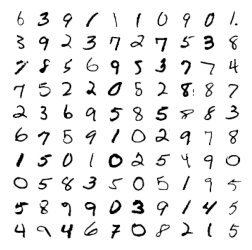

In [10]:
import matplotlib.pyplot as plt

def plot_digits(x, y, n=10):
    plt.figure(figsize=(3, 3))
    for i in range(n**2):
        plt.subplot(n,n,i+1)
        plt.imshow(x[i].reshape(28,28), cmap='Greys')
        plt.axis('off')

plot_digits(x_train, y_train, n=10)

In [11]:
from sklearn.model_selection import GridSearchCV

scaler = MinMaxScaler()
splitter = ShuffleSplit(n_splits=5, random_state=0, train_size=0.5)

C_values = np.logspace(-2, 3, 10)
gamma_values = np.logspace(-3, 0, 10)

# creates the grid search setup
clf = GridSearchCV(estimator=svm.SVC(kernel='rbf'),
                   param_grid={"C": C_values, "gamma": gamma_values})


acc = run(x_train, y_train, splitter, scaler, clf)

print("Hyperparameter estimation (5-fold xval)")
print("    - Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("        Acc: %0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))


acc = run(x_test, y_test, splitter, scaler, clf)
print("    - Best parameters set found on development set:", clf.best_params_)
print(f"    - Accuracy of best clf on test set: {acc.mean():0.3f} (+/-{acc.std()*2:0.03f})")

Hyperparameter estimation (5-fold xval)
    - Grid scores on development set:
        Acc: 0.128 (+/-0.020) for {'C': 0.01, 'gamma': 0.001}
        Acc: 0.128 (+/-0.020) for {'C': 0.01, 'gamma': 0.0021544346900318843}
        Acc: 0.128 (+/-0.020) for {'C': 0.01, 'gamma': 0.004641588833612777}
        Acc: 0.128 (+/-0.020) for {'C': 0.01, 'gamma': 0.01}
        Acc: 0.128 (+/-0.020) for {'C': 0.01, 'gamma': 0.021544346900318832}
        Acc: 0.128 (+/-0.020) for {'C': 0.01, 'gamma': 0.046415888336127774}
        Acc: 0.128 (+/-0.020) for {'C': 0.01, 'gamma': 0.1}
        Acc: 0.128 (+/-0.020) for {'C': 0.01, 'gamma': 0.21544346900318823}
        Acc: 0.128 (+/-0.020) for {'C': 0.01, 'gamma': 0.46415888336127775}
        Acc: 0.128 (+/-0.020) for {'C': 0.01, 'gamma': 1.0}
        Acc: 0.128 (+/-0.020) for {'C': 0.03593813663804628, 'gamma': 0.001}
        Acc: 0.128 (+/-0.020) for {'C': 0.03593813663804628, 'gamma': 0.0021544346900318843}
        Acc: 0.128 (+/-0.020) for {'C': 0.035938

Then, we can also visualize the performances with a colormap. This helps us visually confirm that the best set of hyperparameters is indeed the one selected by the algorithm.

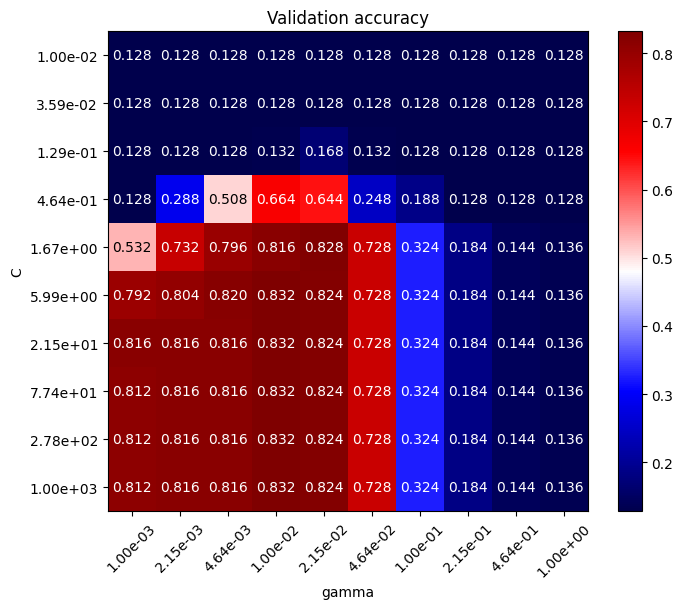

In [15]:
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)

plt.imshow(
    means.reshape(len(C_values), len(gamma_values)),
    interpolation="nearest",
    cmap=plt.cm.seismic,
)
plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar()
plt.xticks(np.arange(len(gamma_values)), map(lambda x: f"{x:.2e}", gamma_values), rotation=45)
plt.yticks(np.arange(len(C_values)), map(lambda x: f"{x:.2e}", C_values))
for (j,i), label in np.ndenumerate(means.reshape(len(C_values), len(gamma_values))):
    plt.text(i,j,f"{label:.3f}",ha='center',va='center', c="k" if 0.4 < label < 0.6 else "w")

plt.title("Validation accuracy")
plt.show()